# BlindDeconvolution

We try to solve the following problem:

$$
arg \;  min_\mathbf{X} \frac{1}{2}||\mathbf{y}-\mathbf{BX}||_2^2 + \mu ||\mathbf{x}||_1 + \delta_{0\le\mathbf{b}\le1} 
$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy import misc
from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *
from pylops.utils.wavelets import *
from pylops.utils.signalprocessing import convmtx


from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.utils.bilinear import BilinearOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.palm import *

In [2]:
class BlindDec(BilinearOperator):
    def __init__(self, x, y, d):
        self.nx = x.size
        self.ny = y.size
        
        self.x = x
        self.y = y
        self.d = d
        self.X = convmtx(x, self.nx)[self.ny//2:self.nx+self.ny//2, :self.ny]
        self.Y = convmtx(self.y, self.nx)[:, self.ny//2:self.nx+self.ny//2]
        self.shapex = (self.nx, self.nx)
        self.shapey = (self.nx, self.ny)

    def __call__(self, x, y):
        xold = self.x.copy()
        self.updatex(x)
        res = self.d - self._matvecy(y)
        self.updatex(xold)
        return np.linalg.norm(res)**2 / 2.

    def updatex(self, x):
        """Update x variable (used when evaluating the gradient over y
        """
        self.x = x

    def updatey(self, y):
        """Update y variable (used when evaluating the gradient over y
        """
        self.y = y

    def _matvecx(self, x):
        Y = convmtx(self.y, self.nx)[:, self.ny//2:self.nx+self.ny//2]
        b = Y @ x
        return b

    def _matvecy(self, y):
        X = convmtx(self.x, self.nx)[self.ny//2:self.nx+self.ny//2, :self.ny]
        b = X @ y
        return b

    def _rmatvecx(self, x):
        Y = convmtx(self.y, self.nx)[:, self.ny//2:self.nx+self.ny//2]
        b = np.conj(Y.T) @ x
        return b

    def _rmatvecy(self, y):
        X = convmtx(self.x, self.nx)[self.ny//2:self.nx+self.ny//2, :self.ny]
        b = np.conj(X.T) @ y
        return b
    
    def matvec(self, x):
        if x.size == self.shapex[1]:
            y = self._matvecx(x)
        else:
            y = self._matvecy(x)
        return y
    
    def rmatvec(self, d, xupd=True):
        if xupd:
            x = self._rmatvecx(d)
        else:
            x = self._rmatvecy(d)
        return x
    
    def lx(self, x):
        X = convmtx(x, self.nx)[self.ny//2:self.nx+self.ny//2, :self.ny]
        lx = np.linalg.norm(np.conj(X).T @ X, 'fro') + 1e-10
        #print('lx', lx)
        return lx

    def ly(self, y):
        Y = convmtx(y, self.nx)[:, self.ny//2:self.nx+self.ny//2]
        ly = np.linalg.norm(np.conj(Y).T @ Y, 'fro') + 1e-10
        #print('ly', ly)
        return ly
    
    def gradx(self, x):
        r = self.d - self.matvec(x)
        g = -self.rmatvec(r, True)
        return g

    def grady(self, y):
        r = self.d - self.matvec(y)
        g = -self.rmatvec(r, False)
        return g

Convolution operator <63x63 Convolve1D with dtype=float32>


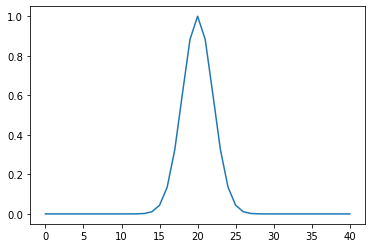

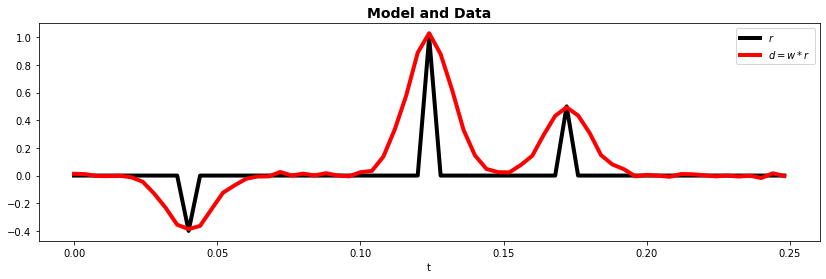

In [3]:
# Model
nt = 63 # this needs to be a odd number to ensure symmetric wavelet in the frequency domain approach
dt = 0.004

t = np.arange(nt) * dt
x = np.zeros(nt)
x[10] = -0.4
x[int(nt / 2)] = 1
x[nt - 20] = 0.5

# Operator
#h, th, hcenter = ricker(t[:21], 20)
h, th, hcenter = gaussian(t[:21], 2)
nh = h.size
Cop = Convolve1D(nt, h=h, offset=hcenter, dtype="float32")
print('Convolution operator', Cop)

# Data
y = Cop * x
y += np.random.normal(0., 1e-2, nt)

plt.figure()
plt.plot(h)

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=4, label=r"$r$")
ax.plot(t, y, "r", lw=4, label=r"$d=w*r$")
ax.set_xlabel("t")
ax.set_title("Model and Data", fontsize=14, fontweight="bold")
ax.legend();

For now we need to rely on dense Toeplitz matrices (as our operator does not handle filters larger than inputs)

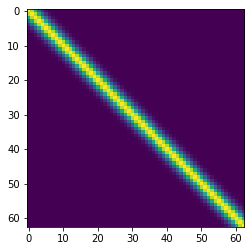

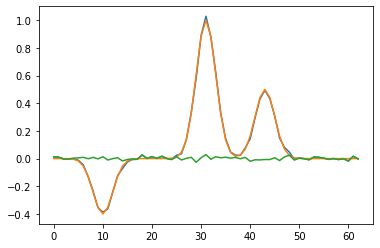

In [4]:
C = convmtx(h, nt)[:, hcenter:nt+hcenter]
plt.figure()
plt.imshow(C)
Copdense = MatrixMult(C)

plt.figure()
plt.plot(y)
plt.plot(Copdense * x)
plt.plot(y-Copdense * x);

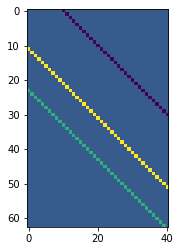

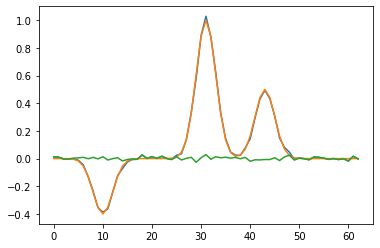

In [5]:
X = convmtx(x, nt)[nh//2:nt+nh//2, :nh]
plt.figure()
plt.imshow(X)

Xopdense = MatrixMult(X)

plt.figure()
plt.plot(y)
plt.plot(Xopdense * h)
plt.plot(y-Xopdense * h);

Testing the operator

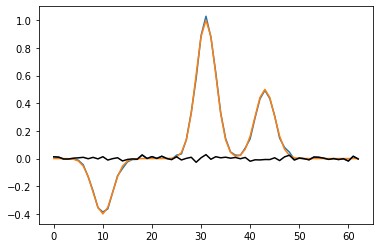

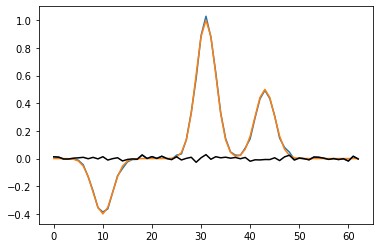

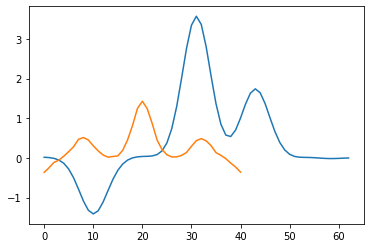

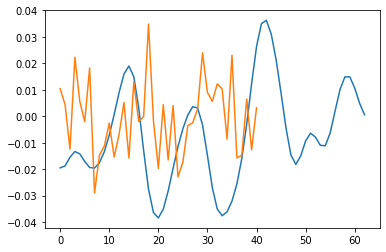

In [6]:
bdec = BlindDec(x, h, y)

# matvec
plt.figure()
plt.plot(y)
plt.plot(bdec.matvec(x))
plt.plot(y-bdec.matvec(x),'k')

plt.figure()
plt.plot(y)
plt.plot(bdec.matvec(h))
plt.plot(y-bdec.matvec(h),'k');

# rmatvec
plt.figure()
plt.plot(bdec.rmatvec(y, True))
plt.plot(bdec.rmatvec(y, False))

# gradient
#bdec.d *= 0
plt.figure()
plt.plot(bdec.gradx(x))
plt.plot(bdec.grady(h));

PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.BlindDec'>
Proximal operator (f): <class 'pyproximal.proximal.L1.L1'>
Proximal operator (g): <class 'pyproximal.proximal.Box.Box'>
gammaf = 1.000000e+00	gammaf = 1.000000e+02	niter = 5000

   Itn      x[0]       y[0]        f         g         H         ck         dk
     1  6.55299e-01  1.78e-04  2.11e-04  0.00e+00  1.89e+01  1.12e+02  7.49e+03
     2  6.48703e-01  3.42e-04  2.06e-04  0.00e+00  1.24e+01  1.12e+02  7.16e+03
     3  6.44092e-01  4.85e-04  2.03e-04  0.00e+00  9.18e+00  1.12e+02  6.93e+03
     4  6.40389e-01  6.06e-04  2.00e-04  0.00e+00  7.34e+00  1.12e+02  6.76e+03
     5  6.37038e-01  7.05e-04  1.98e-04  0.00e+00  6.16e+00  1.12e+02  6.62e+03
     6  6.33740e-01  7.85e-04  1.96e-04  0.00e+00  5.32e+00  1.12e+02  6.50e+03
     7  6.30340e-01  8.48e-04  1.94e-04  0.00e+00  4.67e+00  1.12e+02  6.41e+03
     8  6.26765e-01  8.97e-04  1.92e-04  0.00e+00  4.15e+00  1.

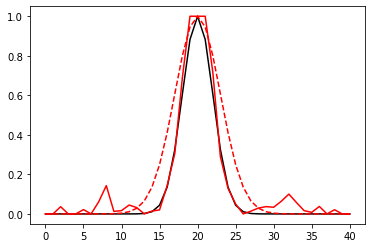

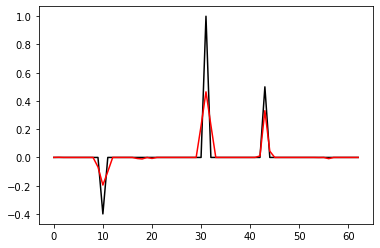

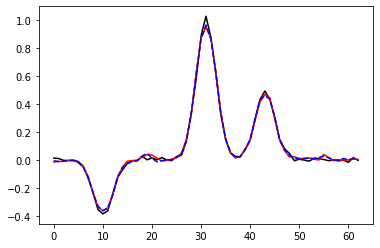

In [7]:
np.random.seed(10)
cx = L1(sigma=1e-5)
ch = Box(lower=0, upper=1) # gaussian
#ch = Box(lower=-.5, upper=1) # ricker

xin = np.random.normal(0., 0.5, nt)#np.zeros(nt)
hin = gaussian(t[:21], 3)[0]
Cop = BlindDec(xin, hin, y)
gammaf=1.
gammag=100.

xest, hest = PALM(Cop, cx, ch, xin, hin, gammaf=gammaf, gammag=gammag, niter=5000, show=True)

plt.figure()
plt.plot(h, 'k')
plt.plot(hin, '--r')
plt.plot(hest, 'r')

plt.figure()
plt.plot(x, 'k')
plt.plot(xest, 'r')

plt.figure()
plt.plot(y, 'k')
plt.plot(Cop.matvec(xest), 'r')
plt.plot(Cop.matvec(hest), '--b');

PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.BlindDec'>
Proximal operator (f): <class 'pyproximal.proximal.L1.L1Ball'>
Proximal operator (g): <class 'pyproximal.proximal.Box.Box'>
gammaf = 1.000000e+00	gammaf = 1.000000e+02	niter = 5000

   Itn      x[0]       y[0]        f         g         H         ck         dk
     1  1.18958e-02  2.73e-05  1.00e+00  0.00e+00  3.11e+00  1.12e+02  4.57e+02
     2  1.45903e-03  0.00e+00  0.00e+00  0.00e+00  2.62e+00  1.12e+02  4.08e+02
     3  0.00000e+00  0.00e+00  0.00e+00  0.00e+00  2.24e+00  1.12e+02  3.68e+02
     4  0.00000e+00  0.00e+00  1.00e+00  0.00e+00  1.95e+00  1.12e+02  3.36e+02
     5  0.00000e+00  0.00e+00  1.00e+00  0.00e+00  1.71e+00  1.12e+02  3.09e+02
     6  0.00000e+00  0.00e+00  1.00e+00  0.00e+00  1.51e+00  1.12e+02  2.87e+02
     7  0.00000e+00  0.00e+00  0.00e+00  0.00e+00  1.34e+00  1.12e+02  2.69e+02
     8  0.00000e+00  0.00e+00  1.00e+00  0.00e+00  1.21e+00

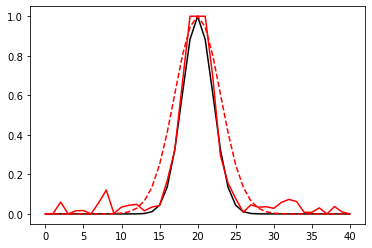

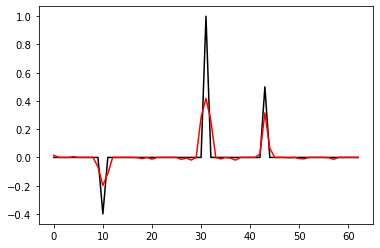

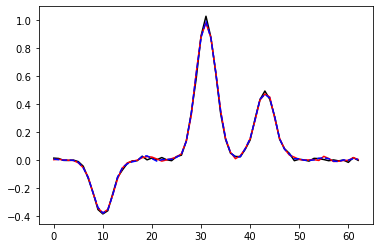

In [8]:
np.random.seed(10)
cx = L1Ball(nt, np.abs(x).sum())
ch = Box(lower=0, upper=1) # gaussian
#ch = Box(lower=-.5, upper=1) # ricker

xin = np.random.normal(0., 0.5, nt)#np.zeros(nt)
hin = gaussian(t[:21], 3)[0]
Cop = BlindDec(xin, hin, y)
gammaf=1.
gammag=100.

xest, hest = PALM(Cop, cx, ch, xin, hin, gammaf=gammaf, gammag=gammag, niter=5000, show=True)

plt.figure()
plt.plot(h, 'k')
plt.plot(hin, '--r')
plt.plot(hest, 'r')

plt.figure()
plt.plot(x, 'k')
plt.plot(xest, 'r')

plt.figure()
plt.plot(y, 'k')
plt.plot(Cop.matvec(xest), 'r')
plt.plot(Cop.matvec(hest), '--b');

PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.BlindDec'>
Proximal operator (f): <class 'pyproximal.proximal.L0.L0Ball'>
Proximal operator (g): <class 'pyproximal.proximal.Box.Box'>
gammaf = 1.000000e+00	gammaf = 1.000000e+02	niter = 5000

   Itn      x[0]       y[0]        f         g         H         ck         dk
     1  0.00000e+00  1.81e-05  1.00e+00  0.00e+00  4.98e+00  2.21e+01  1.95e+03
     2  0.00000e+00  3.74e-05  1.00e+00  0.00e+00  4.61e+00  2.20e+01  1.67e+03
     3  0.00000e+00  5.80e-05  1.00e+00  0.00e+00  4.30e+00  2.20e+01  1.43e+03
     4  0.00000e+00  8.00e-05  1.00e+00  0.00e+00  4.03e+00  2.19e+01  1.23e+03
     5  0.00000e+00  1.03e-04  1.00e+00  0.00e+00  3.81e+00  2.19e+01  1.05e+03
     6  0.00000e+00  1.28e-04  1.00e+00  0.00e+00  3.61e+00  2.18e+01  9.01e+02
     7  0.00000e+00  1.55e-04  1.00e+00  0.00e+00  3.45e+00  2.17e+01  7.73e+02
     8  0.00000e+00  1.84e-04  1.00e+00  0.00e+00  3.31e+00

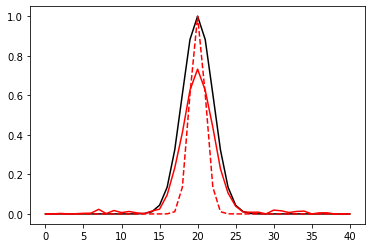

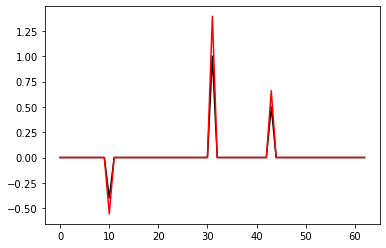

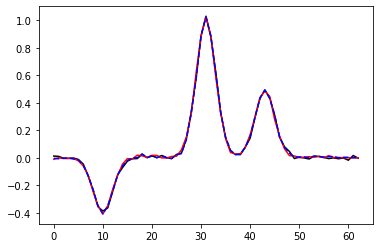

In [19]:
np.random.seed(10)
cx = L0Ball(3)
ch = Box(lower=0, upper=1) # gaussian
#ch = Box(lower=-.5, upper=1) # ricker

xin = np.random.normal(0., 0.5, nt)#np.zeros(nt)
hin = gaussian(t[:21], 1.)[0]
Cop = BlindDec(xin, hin, y)
gammaf=1.
gammag=100.

xest, hest = PALM(Cop, cx, ch, xin, hin, gammaf=gammaf, gammag=gammag, niter=5000, show=True)

plt.figure()
plt.plot(h, 'k')
plt.plot(hin, '--r')
plt.plot(hest, 'r')

plt.figure()
plt.plot(x, 'k')
plt.plot(xest, 'r')

plt.figure()
plt.plot(y, 'k')
plt.plot(Cop.matvec(xest), 'r')
plt.plot(Cop.matvec(hest), '--b');